In [1]:
import pandas as pd
from collections import Counter
import numpy as np
from pycaret.classification import ClassificationExperiment

- The dataset is from the [American Express - Default Prediction](https://www.kaggle.com/competitions/amex-default-prediction/overview)  kaggle competition. 
- Goal of the competition is predict credit default based on the customer's monthly profile.
- For each customer, 189 features are provided in the dataset

In [2]:
train_data = pd.read_feather('../data/train_data.ftr')

In [3]:
train_data.shape

(5531451, 191)

In [5]:
train_data.columns

Index(['customer_ID', 'S_2', 'P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41',
       'B_3',
       ...
       'D_137', 'D_138', 'D_139', 'D_140', 'D_141', 'D_142', 'D_143', 'D_144',
       'D_145', 'target'],
      dtype='object', length=191)

In [6]:
# list of feature columns
feature_cols = [col for col in train_data.columns if col not in ['customer_ID','S_2', 'target']]
# list of categorical columns
cat_cols = [col for col in feature_cols if train_data[col].dtype == 'object']
# list of numerical columns
num_cols = [col for col in feature_cols if train_data[col].dtype != 'object']


In [7]:
train_data.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,...,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,...,NaN,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954102,0.091492,0.021652,1.009766,0.006817,0.123962,0.007599,0.009422,...,NaN,NaN,0.003269,0.007328,0.000427,NaN,0.003429,0.006985,0.002604,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960449,0.002455,0.013687,1.002930,0.001372,0.117188,0.000685,0.005531,...,NaN,NaN,0.006119,0.004517,0.003201,NaN,0.008423,0.006527,0.009598,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947266,0.002483,0.015190,1.000977,0.007607,0.117310,0.004654,0.009308,...,NaN,NaN,0.003672,0.004944,0.008888,NaN,0.001670,0.008125,0.009827,0


The features for each customer are divided into the following 5 categories:
  1. D_* = Delinquency variables
  2. S_* = Spend variables
  3. P_* = Payment variables
  4. B_* = Balance variables
  5. R_* = Risk variables

In [8]:
count_of_feature_type = Counter([
    x.split('_')[0] for x in train_data.columns
    if x not in ['customer_ID', 'target']
])
count_of_feature_type = pd.DataFrame(count_of_feature_type, index=['count']).T
count_of_feature_type

,count
S,22
P,3
D,96
B,40
R,28


0    0.750903
1    0.249097
Name: target, dtype: float64


<AxesSubplot: title={'center': 'Target Distribution'}>

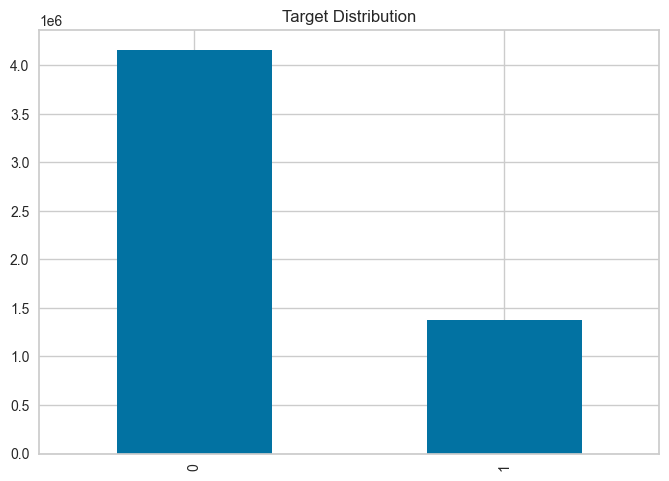

In [9]:
# calculate the percentage of training data that is 1 and 0
print(train_data['target'].value_counts(normalize=True))
train_data['target'].value_counts().plot(kind='bar',
                                         title='Target Distribution')


In [10]:
train_data = train_data.sort_values(by=['customer_ID', 'S_2'])

In [11]:
# Extract the date information from the date column
train_data['Month'] = [i.month for i in train_data['S_2']]
train_data['Day'] = [i.day for i in train_data['S_2']]
train_data['Year'] = [i.year for i in train_data['S_2']]

<AxesSubplot: title={'center': 'Number of rows per customer'}, ylabel='Frequency'>

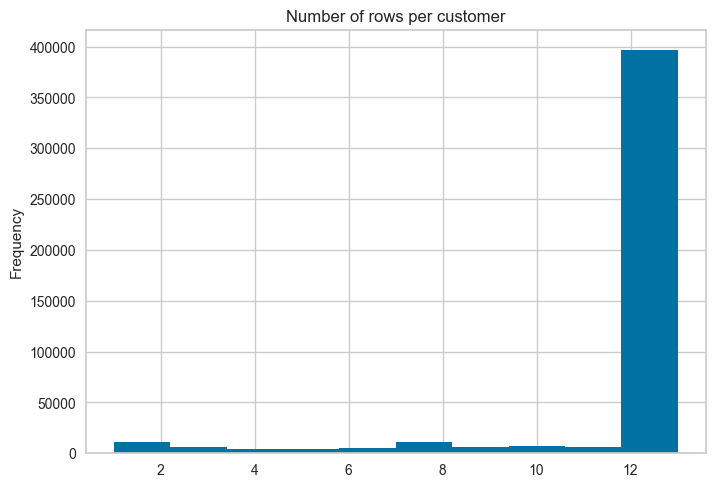

In [12]:
# calculate and plot the number of rows of data for each customer
customer_count = train_data['customer_ID'].value_counts()
customer_count.plot(kind='hist', title='Number of rows per customer')


In [13]:
customer_count.max()

13

In [47]:
# pick random sample of customer_IDs from train_data
np.random.seed(42)
customer_ID_rand = np.random.choice(train_data['customer_ID'], 30000, replace=False)

In [48]:
train_rndm_sample = train_data[train_data['customer_ID'].isin(customer_ID_rand)]


In [49]:
train_rndm_sample.shape

(366008, 194)

In [50]:
train_rndm_sample.to_csv('../data/train_rndm_sample.csv', index=False)

In [19]:
# customer_IDs that are not in the random sample for the training data
customer_ID_not_train = list(set(train_data['customer_ID']).difference(set(customer_ID_rand)))

# pick random sample of customer_IDs from customer_ID_not_train
customer_ID_test_rnd = np.random.choice(customer_ID_not_train, 30000, replace=False)

# test data based on the random sample of customer_IDs
test_rndm_sample = train_data[train_data['customer_ID'].isin(customer_ID_test_rnd)].sort_values(by=['customer_ID', 'S_2'])

In [20]:
test_rndm_sample.shape

(360395, 194)

### Pycaret

In [93]:
# drop customer_ID and S_2 from train and test data
train_rndm_sample.drop(['customer_ID', 'S_2'], axis=1, inplace=True)
test_rndm_sample.drop(['customer_ID', 'S_2'], axis=1, inplace=True)

0    0.761049
1    0.238951
Name: target, dtype: float64


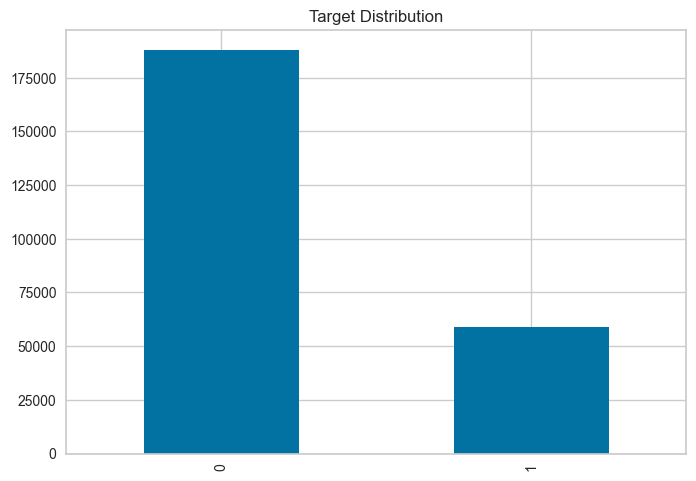

In [94]:
# calculate the percentage of training data sample that is 1 and 0
print(train_rndm_sample['target'].value_counts(normalize=True))
train_rndm_sample['target'].value_counts().plot(kind='bar',
                                         title='Target Distribution');

In [39]:
s = ClassificationExperiment()
s.setup(data=train_rndm_sample, target='target', normalize=True, session_id=123, fix_imbalance=True )

In [40]:
s.models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [42]:
best = s.compare_models(include=['knn', 'xgboost', 'catboost', 'lightgbm', 'dummy'])

In [43]:
s.evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

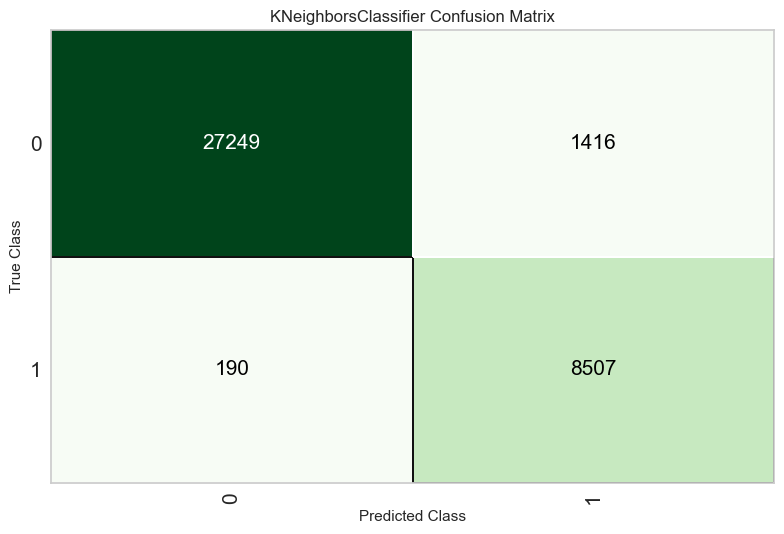

In [44]:
s.plot_model(best, plot = 'confusion_matrix')

In [45]:
pd.DataFrame(s.pull()).sort_values('F1', ascending=False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.9510,0.9902,0.9763,0.8396,0.9028,0.8703,0.8748,5.129
catboost,CatBoost Classifier,0.9417,0.9815,0.8694,0.8789,0.8741,0.8362,0.8362,13.132
xgboost,Extreme Gradient Boosting,0.9241,0.9738,0.8381,0.8363,0.8372,0.7877,0.7877,19.351
lightgbm,Light Gradient Boosting Machine,0.8990,0.9576,0.8072,0.7700,0.7881,0.7218,0.7222,1.645
dummy,Dummy Classifier,0.7672,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.324


In [46]:
# Resutls on the test set based on the best model
predictions_test = s.predict_model(best, data=test_rndm_sample)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,0.8013,0.8546,0.7995,0.5721,0.6669,0.5308,0.5459


### LSTM model

In [14]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam
from keras.metrics import AUC


In [21]:
# Sort the data by customer and then by month
df = train_rndm_sample.copy()
df = df.groupby("customer_ID").filter(lambda x: len(x) <= 13)


# Sort the data by customer and then by date


df["date"] = pd.to_datetime(df["S_2"])
df.drop(["S_2", "Month", "Day", "Year"], axis=1, inplace=True)
df.sort_values(["customer_ID", "date"], inplace=True)
categorical_columns = df.select_dtypes(include=["category"]).columns
categorical_columns
df = pd.get_dummies(df, columns=categorical_columns)


In [22]:
print(df.isna().sum())  # Summarize the count of NaNs by column
print(df.isin([np.inf, -np.inf]).sum())  # Summarize the count of infinite values by column


customer_ID       0
P_2            1741
D_39              0
B_1               0
B_2              53
               ... 
D_120_0.0         0
D_120_1.0         0
D_126_-1.0        0
D_126_0.0         0
D_126_1.0         0
Length: 226, dtype: int64
customer_ID    0
P_2            0
D_39           0
B_1            0
B_2            0
              ..
D_120_0.0      0
D_120_1.0      0
D_126_-1.0     0
D_126_0.0      0
D_126_1.0      0
Length: 226, dtype: int64


In [23]:
df.fillna(df.median(), inplace=True)  # Replace NaNs with the median value of each column
df.replace([np.inf, -np.inf], np.finfo(np.float32).max, inplace=True)  # Replace infinite values with the max float32 value


In [24]:
df.dtypes

customer_ID     object
P_2            float16
D_39           float16
B_1            float16
B_2            float16
                ...   
D_120_0.0        uint8
D_120_1.0        uint8
D_126_-1.0       uint8
D_126_0.0        uint8
D_126_1.0        uint8
Length: 226, dtype: object

In [25]:
from sklearn.preprocessing import StandardScaler

# Assume df is your original dataframe

# features = df.drop('customer_ID', axis=1)  # drop the customer_ID column
float16_columns = df.select_dtypes(include=['float16']).columns

scaler = StandardScaler()
df[float16_columns] = scaler.fit_transform(df[float16_columns])

# If you need to keep the customer_ID in the dataframe for later use, you can add it back




In [26]:
len([x for x in df.columns if x not in ['customer_ID', 'target', 'date']])

223

In [27]:
def get_max_len_and_index_map(df):
    unique_customers = df['customer_ID'].unique()
    customer_index_map = {customer: idx for idx, customer in enumerate(unique_customers)}
    max_len = 0

    for customer in tqdm(unique_customers, desc='Getting max length', total=len(unique_customers)):
        customer_data = df[df['customer_ID'] == customer]
        max_len = max(max_len, len(customer_data))

    return max_len, customer_index_map

In [28]:
def reshape_data(df, max_len, customer_index_map):
    num_customers = len(customer_index_map)
    num_features = df.drop(['customer_ID', 'date', 'target'], axis=1).shape[1]
    X = np.zeros((num_customers, max_len - 12, 12, num_features))
    y = np.zeros((num_customers, max_len - 12))
    mask = np.zeros((num_customers, max_len - 12), dtype=bool)

    df['customer_index'] = df['customer_ID'].map(customer_index_map)
    customer_data = df.groupby('customer_index').apply(
        lambda x: x.drop(['customer_ID', 'date', 'target'], axis=1).values
    )

    for idx, data in customer_data.items():
        num_rows = data.shape[0] - 12 if data.shape[0] > 12 else 0
        if num_rows > 0:
            X[idx, :num_rows] = np.stack([data[i:i+12] for i in range(num_rows)], axis=0)
            y[idx, :num_rows] = df.loc[df['customer_index'] == idx, 'target'].values[12:]
            mask[idx, :num_rows] = True
        elif data.shape[0] > 0:  # handle the case where a customer has less than 12 months of data
            X[idx, 0, :data.shape[0]] = data
            mask[idx, 0] = True

    return X.reshape(-1, 12, num_features), y.reshape(-1), mask.reshape(-1)


In [29]:
max_len, customer_index_map = get_max_len_and_index_map(df)


Getting max length: 100%|██████████| 19596/19596 [02:15<00:00, 144.95it/s]


In [31]:
X, y, mask = reshape_data(df, max_len, customer_index_map)

In [32]:
X.shape

(19596, 12, 224)

In [33]:
# Normalizing the features
scaler = MinMaxScaler()
X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
mask_torch = torch.tensor(mask, dtype=torch.bool)

# Train-test split
X_train, X_test, y_train, y_test, mask_train, mask_test = train_test_split(X, y, mask_torch, test_size=0.2, random_state=42)

# Create DataLoaders
train_dataset = torch.utils.data.TensorDataset(X_train, y_train, mask_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test, mask_test)

train_loader = DataLoader(train_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [34]:
mask_torch.shape

torch.Size([19596])

In [35]:
import torch.nn as nn

class CreditDefaultNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(CreditDefaultNet, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])

        # Add an extra dimension to the end of the tensor
        out = out.unsqueeze(-1)

        return out


In [42]:
# Define the model
import torch
device = torch.device("mps")

model = CreditDefaultNet(input_size=224, hidden_size=64, num_layers=2, output_size=1).to(device)

# Define the loss function and the optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 100
train_losses = []
for epoch in range(num_epochs):
    for i, (inputs, labels, mask) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        mask = mask.to(device)

        # Forward pass
        outputs = model(inputs).squeeze(1)  # outputs shape should be [batch_size] to match mask shape

        # print("Outputs shape:", outputs.shape)
        # print("Labels shape:", labels.shape)
        # print("Mask shape:", mask.shape)

        # mask = mask.view(-1)

        # Reshape the labels to match the outputs
        labels = labels.unsqueeze(1)

        loss = criterion(outputs[mask], labels[mask])

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Logging
        if (i+1) % 200 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
            train_losses.append(loss.item())



Epoch [1/100], Step [200/490], Loss: 0.3195
Epoch [1/100], Step [400/490], Loss: 0.2044
Epoch [2/100], Step [200/490], Loss: 0.2496
Epoch [2/100], Step [400/490], Loss: 0.1944
Epoch [3/100], Step [200/490], Loss: 0.2347
Epoch [3/100], Step [400/490], Loss: 0.1926
Epoch [4/100], Step [200/490], Loss: 0.2287
Epoch [4/100], Step [400/490], Loss: 0.1909
Epoch [5/100], Step [200/490], Loss: 0.2286
Epoch [5/100], Step [400/490], Loss: 0.1859
Epoch [6/100], Step [200/490], Loss: 0.2295
Epoch [6/100], Step [400/490], Loss: 0.1793
Epoch [7/100], Step [200/490], Loss: 0.2290
Epoch [7/100], Step [400/490], Loss: 0.1716
Epoch [8/100], Step [200/490], Loss: 0.2276
Epoch [8/100], Step [400/490], Loss: 0.1635
Epoch [9/100], Step [200/490], Loss: 0.2268
Epoch [9/100], Step [400/490], Loss: 0.1557
Epoch [10/100], Step [200/490], Loss: 0.2268
Epoch [10/100], Step [400/490], Loss: 0.1486
Epoch [11/100], Step [200/490], Loss: 0.2276
Epoch [11/100], Step [400/490], Loss: 0.1423
Epoch [12/100], Step [200/49

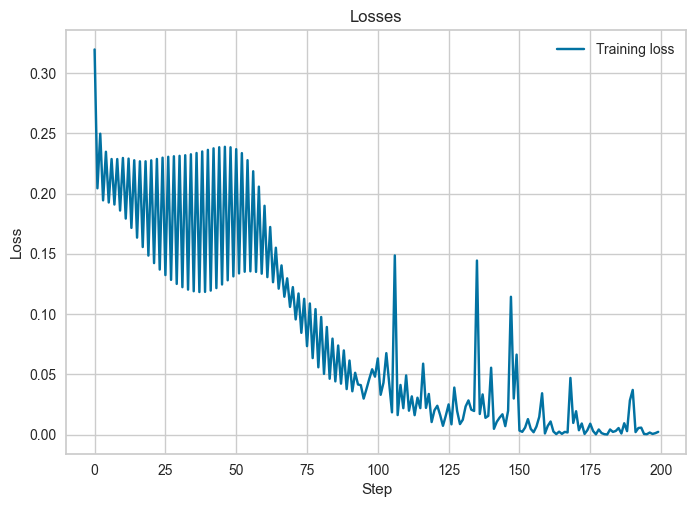

In [43]:
import matplotlib.pyplot as plt

# Plot the training losses
plt.plot(train_losses, label='Training loss')
plt.title('Losses')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [44]:
torch.save(model, '../models/credit_default_model_05_18_2023.pt')


In [45]:
test_dataset = TensorDataset(X_test, y_test, mask_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()  # set the model to evaluation mode

test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels, mask in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        mask = mask.to(device)

        # Forward pass
        # Forward pass
        outputs = model(inputs).squeeze()


        # Compute test loss
        loss = criterion(outputs[mask], labels[mask])
        test_loss += loss.item()

        # Convert model output probabilities to predicted class (0 or 1)
        predicted = torch.round(torch.sigmoid(outputs))  # Sigmoid function to convert output to a probability that sum up to 1
        correct += (predicted[mask] == labels[mask]).sum().item()
        total += mask.sum().item()

# Print test metrics
print('Test Loss: ', test_loss / len(test_loader))
print('Test Accuracy: ', correct / total)


Test Loss:  0.8837281699951102
Test Accuracy:  0.8714285714285714
